# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm

import pandas as pd
import numpy as np

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Setup Seaborn
sns.set(style='whitegrid', font_scale=0.8, rc={"lines.linewidth":2, 'grid.color': '.8', 'grid.linestyle':':'})
sns.set_context("poster")
# Set up Matplotlib
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_offers.shape

(32, 7)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_transactions.shape

(324, 3)

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html"> 'merge'</a> and <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html">'pivot_table'</a> functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
## merge df_transactions and df_offers to have all info on whether customers responded to offer(s)
df = pd.merge(df_transactions, df_offers, how='outer', on='offer_id').sort_values(by='customer_name')[['customer_name', 'offer_id', 'n']]
## pivot table to easily check which offer the customer responded to
df = df.pivot_table(values='n', index='customer_name', columns='offer_id', fill_value=0)

In [7]:
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [8]:
df.shape

(100, 32)

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">'KMeans'</a> clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

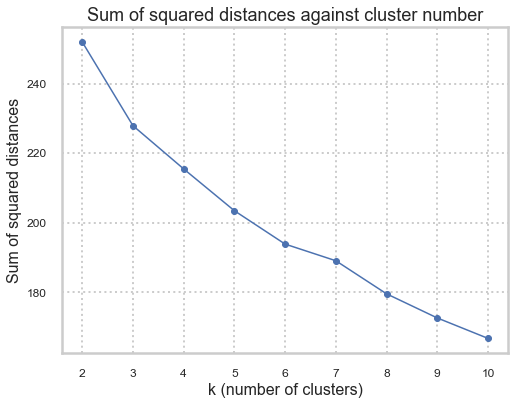

In [9]:
## Squared sum holder
inertias = []
## X: values of indicators
X = df.values

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=476).fit(X)
    inertias.append(kmeans.inertia_)
    
## visualize scree plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(range(2,11), inertias, marker='.', linewidth=1.5)
plt.ylabel("Sum of squared distances", fontsize=16)
plt.xlabel("k (number of clusters)", fontsize=16)
plt.title("Sum of squared distances against cluster number", fontsize=18);



It is very hard to find "the elbow" point; therefore, I will choose 6 as the best K for now.

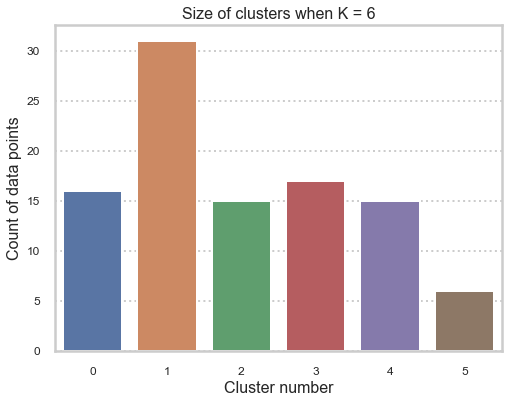

In [10]:
kmeans = KMeans(n_clusters=6, random_state=476).fit(X)
## get labels predicted
labels = kmeans.predict(X)
## get cluster label and counts
clusters, counts = np.unique(labels, return_counts=True)

## visualize bar plot - number of points in each cluster
plt.figure(figsize=(8,6))
ax = sns.barplot(clusters, counts)
plt.xlabel("Cluster number", fontsize=16)
plt.ylabel("Count of data points", fontsize=16)
plt.title("Size of clusters when K = 6", fontsize=16);

***
### Q. What values of  SS do you believe represent better clusterings? Why?
Since SS represents the sum of inner cluster variances, the smaller, the better. Smaller SS value means how compactly data points are clustered around the centroids. 

### Q. What challenges did you experience using the Elbow method to pick  K?
There is no clear elbow point. Also, by nature, as K increases, SS value decreases. All in all, with naked eyes we cannot confidently decide best K.
***

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.08646928072968546


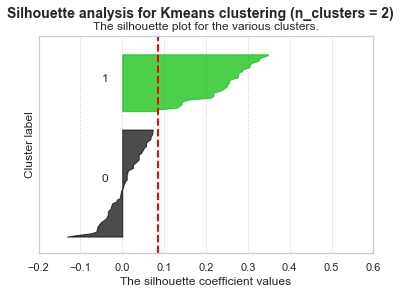

For n_clusters = 3 The average silhouette_score is : 0.12122715317053197


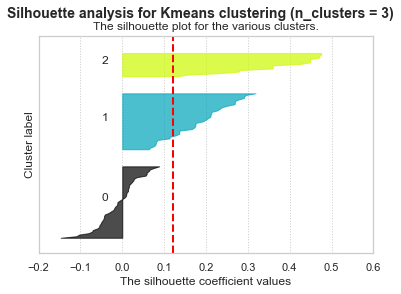

For n_clusters = 4 The average silhouette_score is : 0.13211960791852279


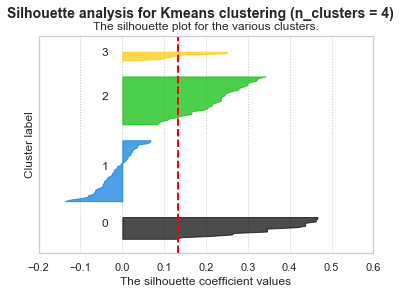

For n_clusters = 5 The average silhouette_score is : 0.1293963610475833


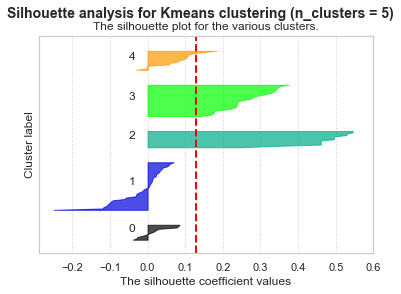

For n_clusters = 6 The average silhouette_score is : 0.11118261289979597


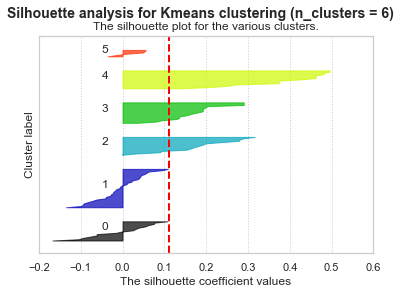

For n_clusters = 7 The average silhouette_score is : 0.10561253091025762


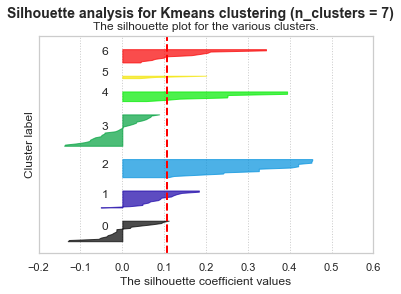

For n_clusters = 8 The average silhouette_score is : 0.12512114664772778


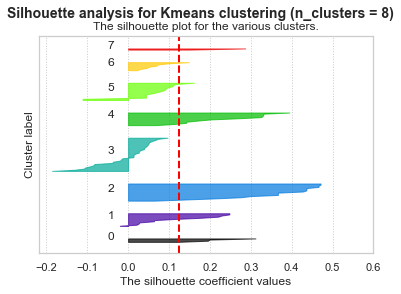

For n_clusters = 9 The average silhouette_score is : 0.11722060414685397


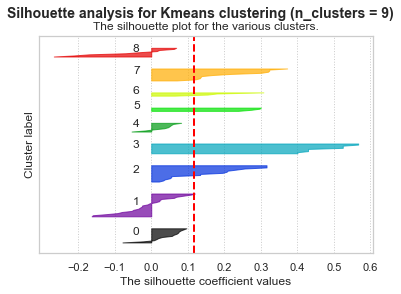

For n_clusters = 10 The average silhouette_score is : 0.1044844143489517


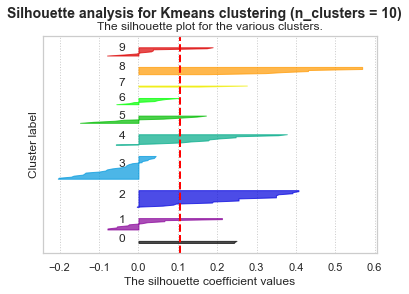

In [11]:
sns.set(style='whitegrid', font_scale=1, rc={"lines.linewidth":2, 'grid.color': '.8', 'grid.linestyle':':'})
silhouette_scores = []

for n_clusters in range(2, 11):
    ## Create a subplot 
    fig, ax = plt.subplots(1,1)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=476)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    
    plt.suptitle(("Silhouette analysis for Kmeans clustering "
                  "(n_clusters = {})".format(n_clusters)), 
                 fontsize=14, fontweight='bold')
    plt.show()

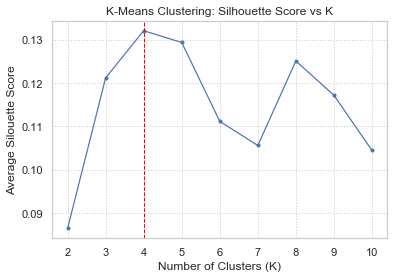

Best cluster number K is 4 with average silhouette score 0.132120


In [12]:
plt.plot(range(2,11), silhouette_scores, marker='.', linewidth=1.2)
plt.axvline(x=np.argmax(silhouette_scores)+2, color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silouette Score')
plt.title('K-Means Clustering: Silhouette Score vs K')
plt.show()

print("Best cluster number K is {} with average silhouette score {:.6f}".format(np.argmax(silhouette_scores)+2, np.max(silhouette_scores)))

***
### Q. Compute the average silhouette score for each  K. What  K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

Based on average silhouette scores, K = 4 seems the optimal choice, because greater average silhouette scores indicates that clusteres are compact with its members but well seperated from other clusters in general. Unlike the Elbow method, we do not have make a subjective decision for K, we can objectively pick the best K with numerical values.
***

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

***
### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures. It has bounded range of \[-1, 1] -  negative values are bad (independent labelings), similar clusterings have a positive ARI, 1.0 is the perfect match score.

* Adjusted Rand Index:  
Given the knowledge of the ground truth class, rand Index (RI) denotes how well each pairs are grouped and seperated. However the RI score does not guarantee that random label assignments will get a value close to zero. Therefore we employ ARI to counter this effect by discounting expected RI of random labellings. 

* Mutual Information:  
Mutual information measures the information that X and Y share: It measures how much knowing one of these variables reduces uncertainty about the other. For example, if X and Y are independent, then knowing X does not give any information about {\displaystyle Y} Y and vice versa, so their mutual information is zero. Like the Rand index, the baseline value of mutual information between two random clusterings does not take on a constant value, and tends to be larger when the two partitions have a larger number of clusters. AMI subtracts the expectation value of the MI, so that the AMI is zero when two different distributions are random, and one when two distributions are identical.

* V-Measure:  
Given the knowledge of the ground truth class assignments of the samples, the V-Measure is defined as the harmonic mean of homogeneity h and completeness c of the clustering. Homogeneity h is maximized when each cluster contains elements of as few different classes as possible. Completeness c aims to put all elements of each class in single clusters. To add more intuition behind harmonic mean, harmonic mean is usually used to achieve **average rate/proportion** among different rates. When 2 rates are used as in this case (h & c), you can interpret harmonic mean as "get the best of both worlds" because we want high homogeneity, and at the same time high completeness as well. Harmonic mean (V-measure) represents both rates well as the average. Also, harmonic mean punishes extreme values. For example, if h = 1, and c = 0, then V-measure is 0, unlike 0.5 of arithmetic mean - harmonic mean is more stable than arithmetic mean.  

* Fowlkes–Mallows index:  
The Fowlkes-Mallows Index is the geometric mean of precision and recall. As with V-measure, the Fowlkes-Mallows index can be used when the ground truth class assignments of the samples is known. The geometric mean (GM) handles proportions in a consistent manner, whereas the other measure do not. It means the final proportion can be graphed right along with the average whole and average part — and there is no possible inconsistency. In order word, whether you achieve geometric mean of proportions as a whole (e.g., GM(2/2, 1/6, 6/7)) or denominators and numerators seperately (i.e., GM(2, 1, 6) / GM(2, 6, 7)), you end up with the same value (0.52). The average of proportions (arithmetic mean), on the other hand, treats each item equally (as does the geometric mean). This is desirable when only the proportion itself matters, not the size of the samples. Since both recall and precision are proportions, we can interpret Fowlkes–Mallows index as how many TP's are among TP + FP + FN.  (\** TP: True Positive, FP: False Positive, FN: False Negative) in average. 

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.
***

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">'PCA' </a> function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

## Visualize clusters with PCA based on original data

In [13]:
def clustering_with_model(X, model, reduction=True, show=True, annot=True, figsize=(13,13), **kwargs):
    ## PCA
    pca = PCA(n_components=2, random_state=8921)
    ## get reduced data
    X_pca = pca.fit_transform(X)
    
    ## get labels
    if reduction: # use pca data
        clusterer = model(**kwargs).fit(X_pca)
        cluster_labels = clusterer.labels_
    else: # use original data
        clusterer = model(**kwargs).fit(X)
        cluster_labels = clusterer.labels_

    ## make df_pca
    df_pca = pd.DataFrame(X_pca, columns=['pc1', 'pc2'])
    df_pca['label'] = cluster_labels

    ## get df_all for all info of transactions and offers
    df_all = pd.merge(df_transactions, df_offers, how='outer', on='offer_id').sort_values(by='customer_name')

    ## add customer name to df_pca
    df_pca['customer_name'] = df.index
    df_pca = df_pca[['customer_name', 'label', 'pc1', 'pc2']]
    
    ## combine all dataframes into df_all
    df_all = pd.merge(df_all, df_pca, how='outer', on='customer_name')
    
    ## cluster numbers 
    cluster_numbers = sorted(df_pca.label.unique())
    
    if show:
        ## Draw scatter plot with annotation
        fig = plt.figure(figsize=figsize)
        ## set cmap
        cmaps = []
        if len(cluster_numbers) <= 6:
            cmaps.append(cm.Paired)
            cmap = [cmaps[0](i*2+1) for i in range(len(cluster_numbers))]
        elif len(cluster_numbers) <= 10:
            cmaps.append(cm.tab10)
            cmap = [cmaps[0](i*2+1) for i in range(len(cluster_numbers))]
        else:
            cmaps.append(cm.Set1)
            cmaps.append(cm.Set2)
            cmaps.append(cm.Set3)
            cmap = [cmaps[0](i) for i in range(9)]
            cmap.extend([cmaps[1](i) for i in range(1, 8)])
            cmap.extend([cmaps[2](i) for i in range(12)])
        ## scatter plot
        for i in cluster_numbers:
            plt.scatter(df_pca[df_pca.label==i].pc1 , df_pca[df_pca.label==i].pc2, c = cmap[i])
            loc = zip(df_pca[df_pca.label==i].pc1, df_pca[df_pca.label==i].pc2)
            if annot:
                for pos, axis in enumerate(loc):
                    x,y = axis
                    plt.text(x,y, str(df_pca[df_pca.label==i].iloc[pos,0]), size =12)
        ## get labels for legend
        labels = ['Cluster '+str(i) for i in cluster_numbers]
        if figsize == (13,13):
            plt.legend(labels, loc='upper left')
        else:
            plt.legend(labels, loc='best')
       
        plt.title("Customer map on PC1 & PC2 (K = {})".format(len(cluster_numbers)), fontsize=16)
        plt.xlabel("PC1", fontsize=14)
        plt.ylabel("PC2", fontsize=14)
        plt.show()

    return df_pca, df_all, X_pca

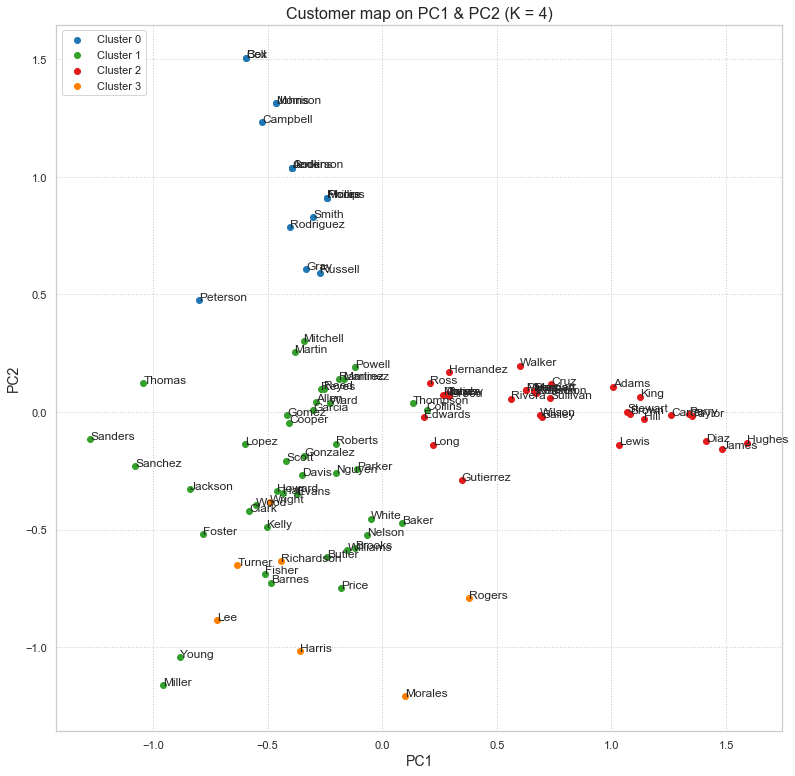

In [14]:
## visualize clusters 
_, _, X_pca = clustering_with_model(X, KMeans, reduction=False, show=True, n_clusters=4, random_state=476)

***
### Q. How do the clusters look?
With the PCA dimension reduction down to 2D, it seems clusters based on original data look well seperated except for cluster 1 and cluster 3. 

### Q. Based on what you see, what seems to be the best value for  K? Moreover, which method of choosing  K seems to have produced the optimal result visually?
Given that cluster 1 and cluster 3 are overlapping, it seems promising to choose 3 for K. As to clustering evaluation, we should cross off ARI, AMI(Adjusted Mutual Information), V-measure and Fowlkes–Mallows index due to the absence of ground truth labels. __Since we do not have true class labels, silhouette method provides the most objective evaluation for clustering.__ In general, ARI and AMI are commonly used provided the gound truth clustering. The rule of thumb is:
- Use ARI when the ground truth clustering has large equal sized clusters
- Usa AMI when the ground truth clustering is unbalanced and there exist small clusters.
***

## Clustering based on pc1, pc2
### Find the best K with silhouette method

For n_clusters = 2 The average silhouette_score is : 0.41220654905764287


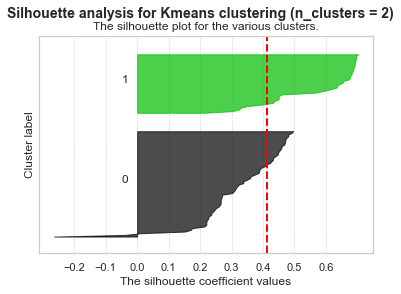

For n_clusters = 3 The average silhouette_score is : 0.5303468047950125


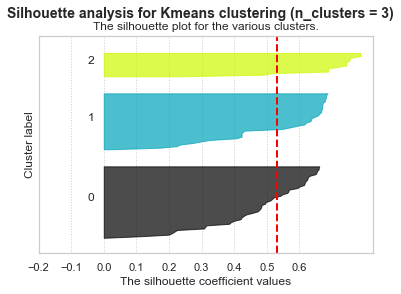

For n_clusters = 4 The average silhouette_score is : 0.44880129380706096


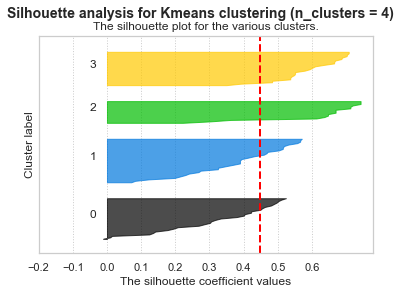

For n_clusters = 5 The average silhouette_score is : 0.4689961174534534


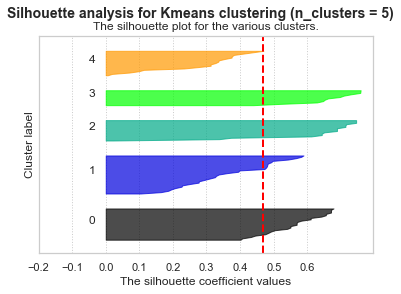

For n_clusters = 6 The average silhouette_score is : 0.4774142406175623


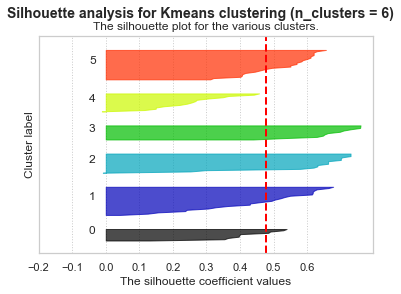

For n_clusters = 7 The average silhouette_score is : 0.46722861750140565


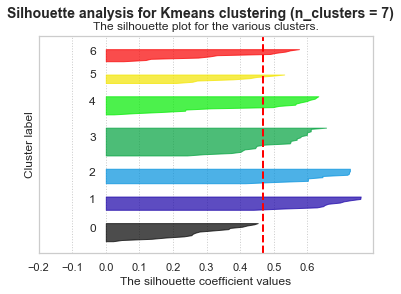

For n_clusters = 8 The average silhouette_score is : 0.5141995071472699


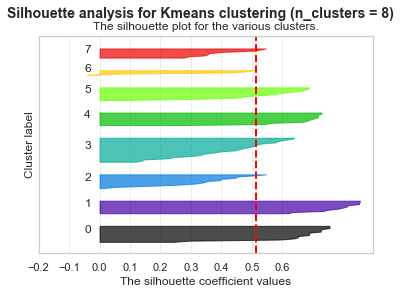

For n_clusters = 9 The average silhouette_score is : 0.5067501091969514


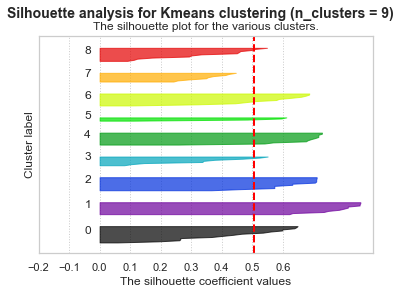

For n_clusters = 10 The average silhouette_score is : 0.5086138282603226


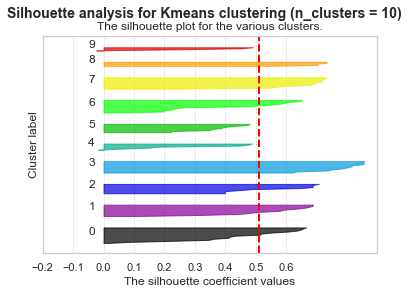

In [15]:
silhouette_scores = []

for n_clusters in range(2, 11):
    ## Create a subplot 
    fig, ax = plt.subplots(1,1)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=476)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    
    plt.suptitle(("Silhouette analysis for Kmeans clustering "
                  "(n_clusters = {})".format(n_clusters)), 
                 fontsize=14, fontweight='bold')
    plt.show()

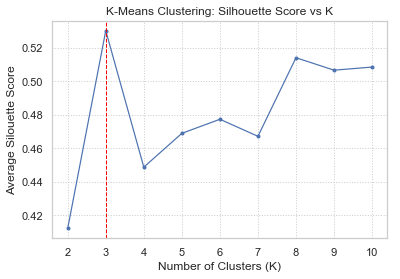

Best cluster number K is 3 with average silhouette score 0.530347


In [16]:
plt.plot(range(2,11), silhouette_scores, marker='.', linewidth=1.2)
plt.axvline(x=np.argmax(silhouette_scores)+2, color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silouette Score')
plt.title('K-Means Clustering: Silhouette Score vs K')
plt.show()

print("Best cluster number K is {} with average silhouette score {:.6f}".format(np.argmax(silhouette_scores)+2, np.max(silhouette_scores)))

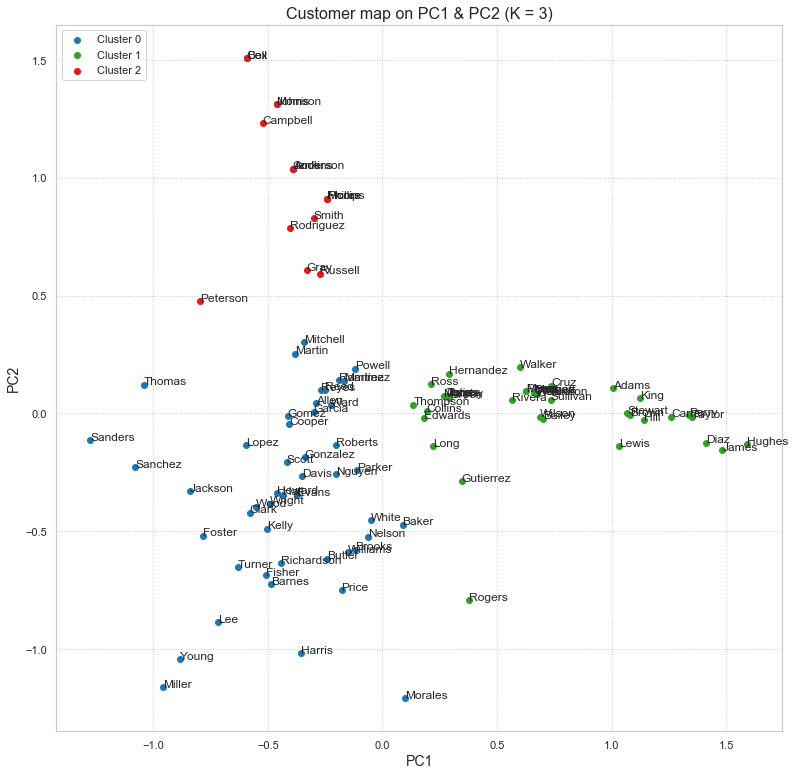

In [17]:
df_pca, df_all, _ = clustering_with_model(X, KMeans, reduction=True, show=True, n_clusters=3, random_state=476)

***
### Analysis
As we expected earlier, the clustering results based on PC1 and PC2 (i.e., principal components),average silhouette score results in the highest at K = 3. Also, looking at individual silhouette analysis chart, silhouette scores for all data points are positive unlike previously. This indicates that with 2 PC's K-means algorithm seperates cluster better than with original data features (high dimension). 
***

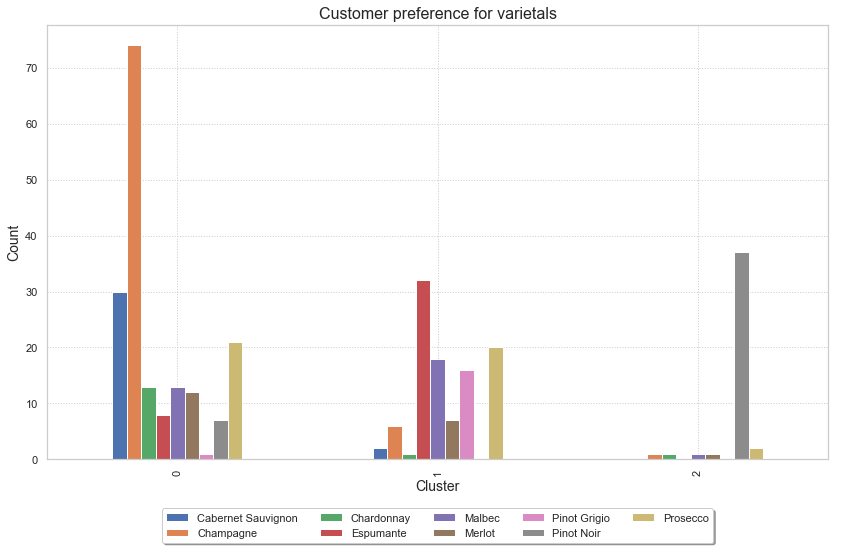

In [18]:
## make pivot tables of cluster labels and ['varietal', 'origin', 'campaign']
df_varietal = df_all.pivot_table(values='n', index='label', columns='varietal', fill_value=0, aggfunc='count')
df_origin = df_all.pivot_table(values='n', index='label', columns='origin', fill_value=0, aggfunc='count')
df_campaign = df_all.pivot_table(values='n', index='label', columns='campaign', fill_value=0, aggfunc='count')
## reorganized to cardinal order
df_campaign = df_campaign[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

## show barplot of df_varietal
df_varietal.plot(kind='bar', figsize=(14,8))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.title('Customer preference for varietals', fontsize=16)
plt.show()

***
### Analysis
When it comes to the varietals, customers assigned to 
* cluster 0 have strong preference for Champagne, Carbernet Sauvignon, and Chardonnay. 
* cluster 1 are Espumante & Pinot Grigio lovers and like customers in cluster 0, they like Malbec and Meriot as well. 
* cluster 2 are huge fans of Pinot Noir.
***

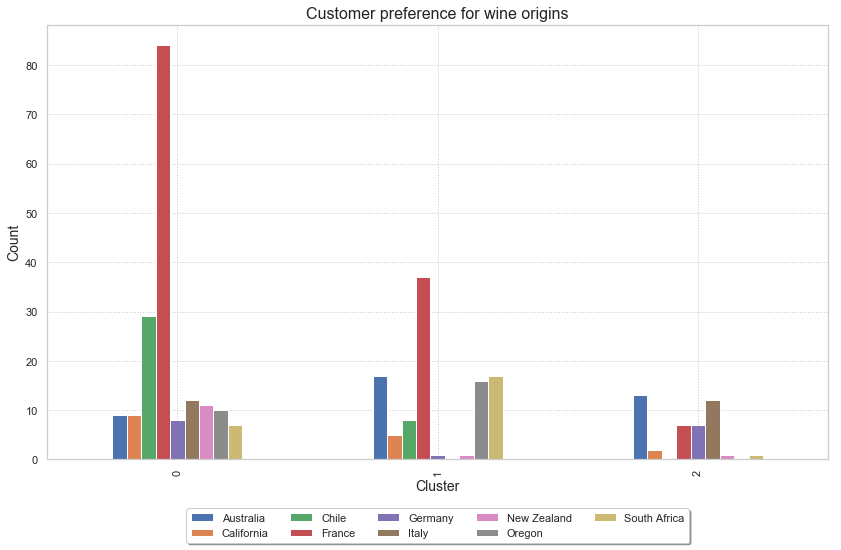

In [19]:
## show barplot of df_origin
df_origin.plot(kind='bar', figsize=(14,8))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.title('Customer preference for wine origins', fontsize=16)
plt.show()

***
### Analysis
When it comes to the wine origins, customers assigned to 
* cluster 0 have very strong preference for wines from France and Chile especially. They seem to have wide range of taste for wine origines. 
* cluster 1 love French and Australlian wine. They also favor South African and Oregon-origin wine. 
* cluster 2 care for mostly favors Austrailian, French, German, and Italian wine.
***

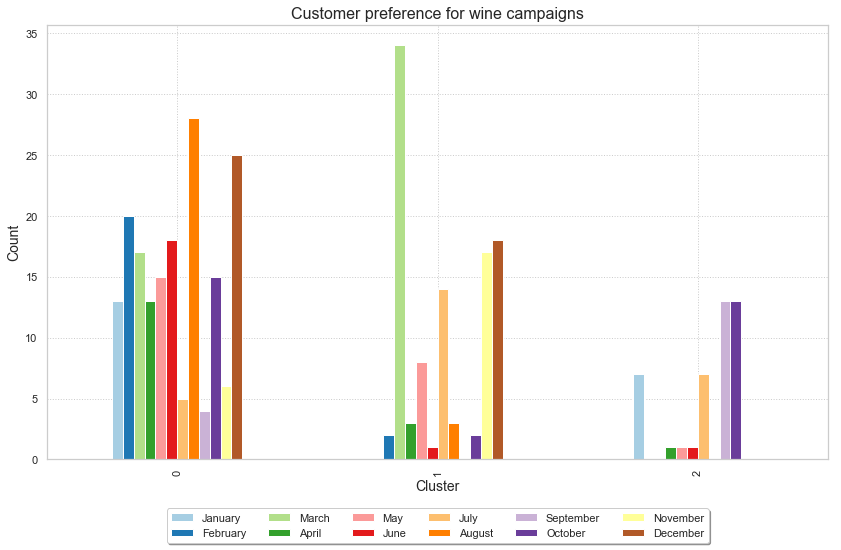

In [20]:
## show barplot of df_campaign
df_campaign.plot(kind='bar', figsize=(14,8), cmap='Paired')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=6)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.title('Customer preference for wine campaigns', fontsize=16)
plt.show()

***
### Analysis
When it comes to the wine campaigns, customers assigned to 
* cluster 0 seem to have wide range of taste for wine campaigns. However, they less favor July, September, and November wine.  
* cluster 1 show strong predilection for March wine followed by December, November, July and May. 
* cluster 2 want September, October, January and July wine mostly. 
***

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

## Elbow method & Explained variance

In [21]:
def pca_plot(pca):
    length = len(pca.explained_variance_)
    component_num = range(1, length+1)
    values = pca.explained_variance_
    
    plt.figure(figsize=(12,6))
    plt.plot(component_num, values)
    plt.scatter(component_num, values, marker='o', s=25)
    plt.ylabel("Variance Explained (%)", fontsize=14)
    plt.xlabel("Principal Component", fontsize=14)
    plt.title("Explained variance per principal component", fontsize=16)
    
    plt.arrow(11,0.28,-6.35, -0.1, head_width=0.01, head_length=0.3, fc='k', ec='k')
    plt.arrow(11,0.28,-5.45, -0.115, head_width=0.01, head_length=0.3, fc='k', ec='k')
    plt.text(11.3,0.28, 'Possible Optimal K\'s: 4 & 5')
    
    plt.xticks([0,1, 5, 10, 15, 20, 25, 30, 32])
    sns.despine(top=True, right=True)

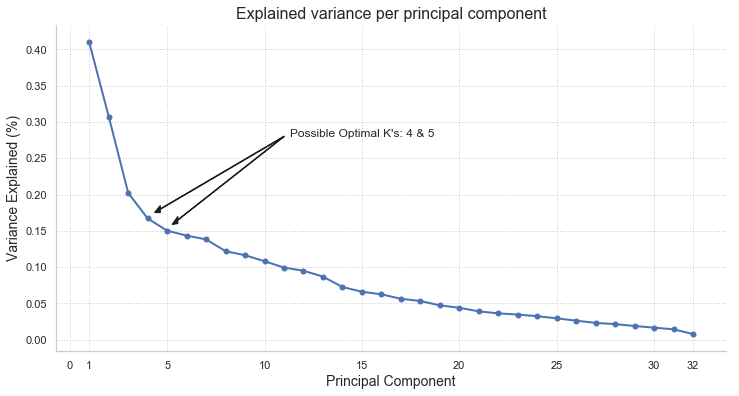

In [22]:
## PCA with default n_components
pca2 = PCA(random_state=8921)
pca2.fit(X)

pca_plot(pca2)

***
### Analysis
With the help of explained variance per principal component we can gauge how important role a PC plays for clustering. Like the Elbow method, the bending point where the slope plummets is a candidate value for optimal number of dimensions because that the slope declines means from the elbow point, the variance of a PC accounts for does not vary much therefore adding more PC does not help the performance of clustering less the curse of dimensionality. In the graph, possible optimal K value seems either 4 or 5. 

***

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn <a name="figure1"></a>
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<table><tr>
    <td>
        <figure>
        <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" style="height:600px" align='right'>
            <figcaption> (Figure 1: Comparing different clustering algorithms on toy datasets - scikit-learn) </figcaption>
        </figure>
    </td>
</tr></table>

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation

damping: 0.5


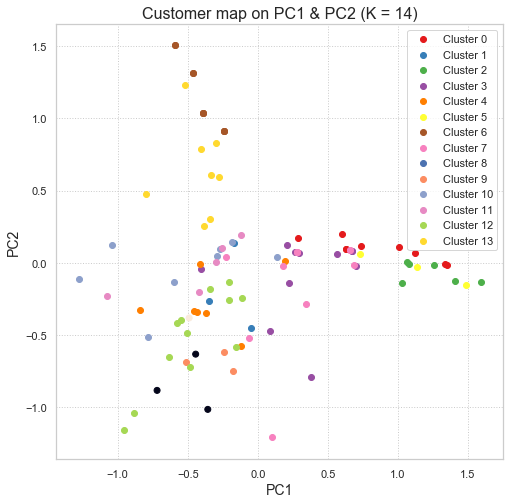

damping: 0.6


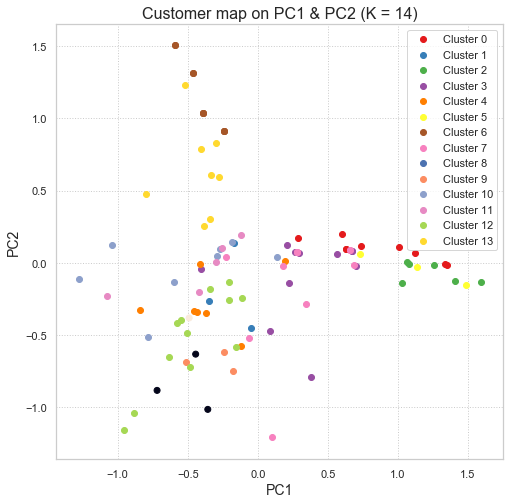

damping: 0.7


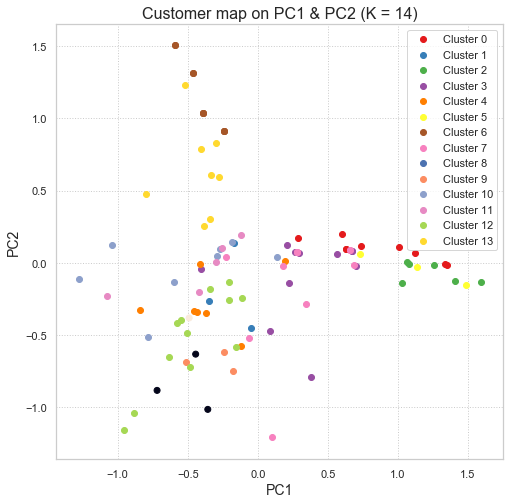

damping: 0.8


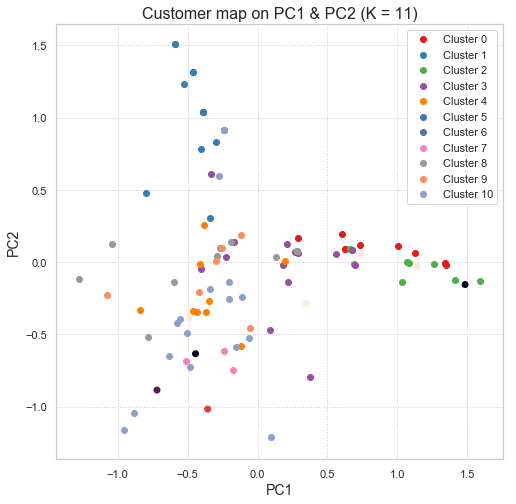

damping: 0.9


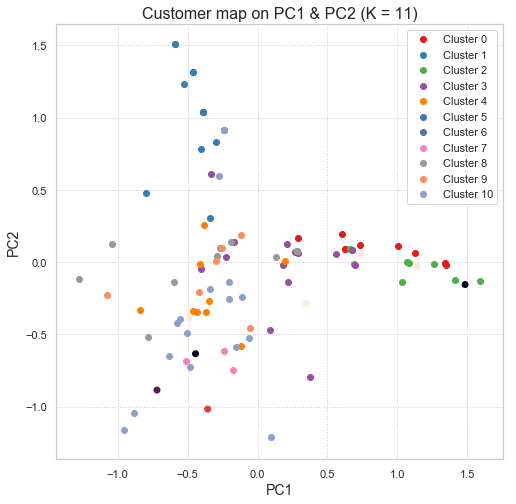

In [23]:
## AffinityPropagation
for damping in np.linspace(0.5, 0.9, 5):
    print("damping: {:.1f}".format(damping))
    _, _, _ = clustering_with_model(X, AffinityPropagation, reduction=False, show=True, annot=False, figsize=(8,8), damping=damping)

AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

Affinity Propagation can be interesting as it chooses the number of clusters based on the data provided. For this purpose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

I used the default setting for preference and changed damping value from 0.5 to 0.9; however fail to see significant improvement; thus concluding that it is not the optimal choice for problem dataset.


### Spectral Clustering

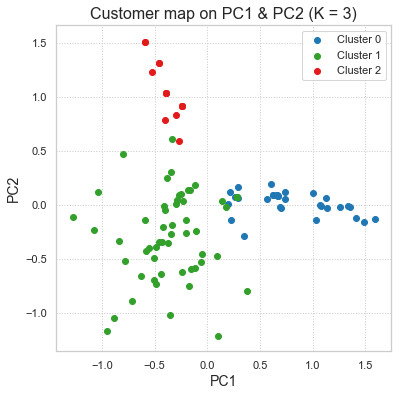

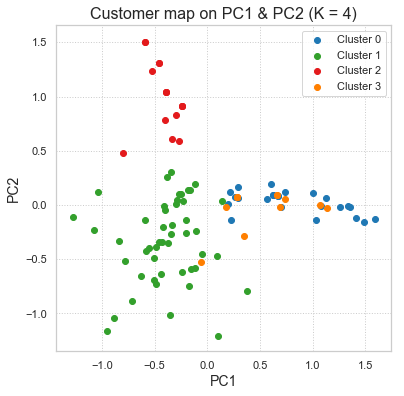

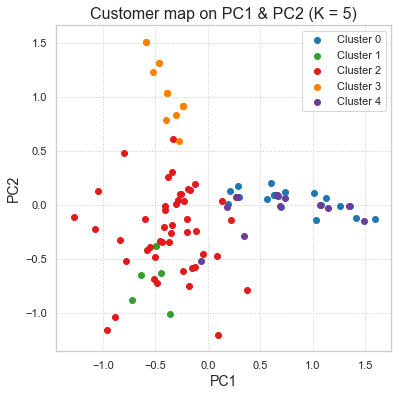

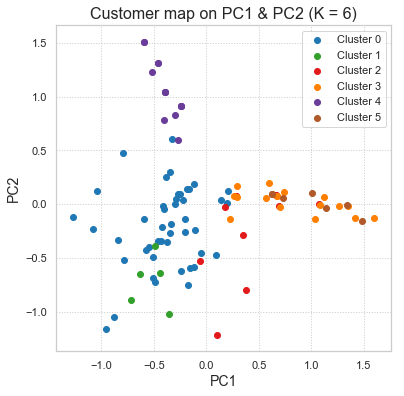

In [24]:
## SpectralClustering
for k in range(3, 7):
    _, _, _ = clustering_with_model(X, SpectralClustering, reduction=False, annot=False, figsize=(6,6), n_clusters=k)

SpectralClustering does a low-dimension embedding of the affinity (similarity) matrix between samples, followed by a KMeans in the low dimensional space. It is especially efficient if the affinity matrix is sparse. Affinity is a metric that determines how close, or Similar, two points are in feature space. Default affinity in scikit-learn spectralclustering module is 'rbf'. SpectralClustering requires the number of clusters to be specified. It works well for a small number of clusters but is not advised when using many clusters. 

With our dataset, spectral clustering with K=3 shows very similar result to the Kmeans mode. 

## Agglomerative Clustering

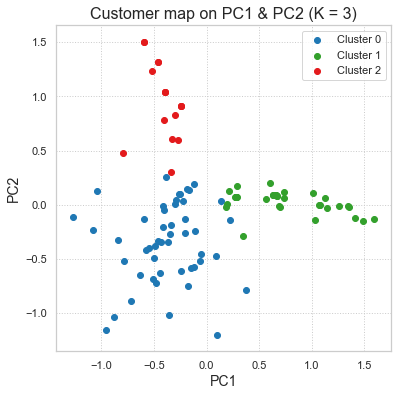

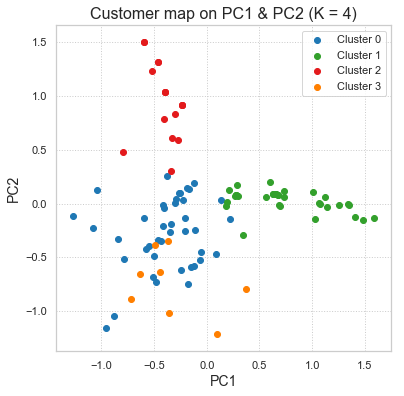

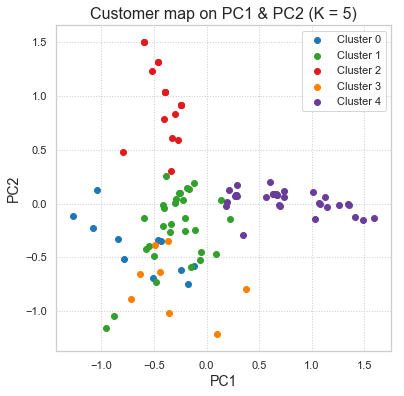

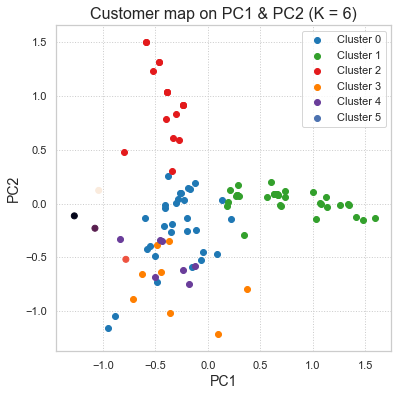

In [25]:
## AgglomerativeClustering
for k in range(3, 7):
    _, _, _ = clustering_with_model(X, AgglomerativeClustering, reduction=False, annot=False, figsize=(6,6), n_clusters=k)

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy and by default AgglomerativeClustering uses Ward's method
- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

With our dataset, the model result is very similar to Kmeans model as well. 

eps: 0.9


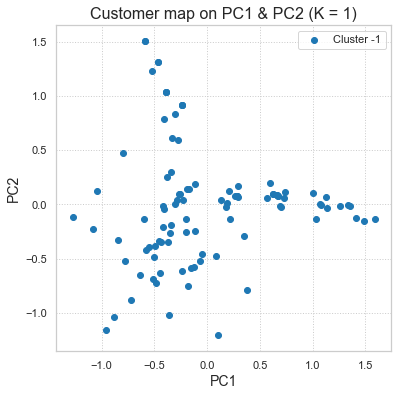

eps: 1.0


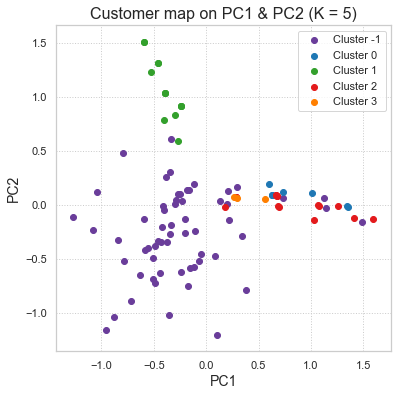

eps: 1.1


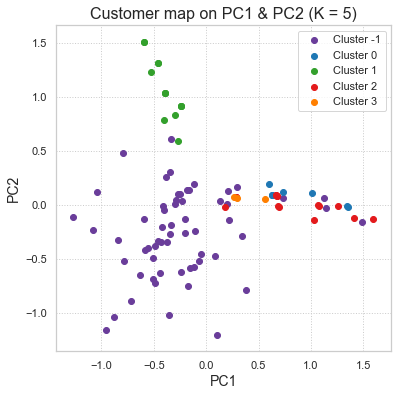

eps: 1.2


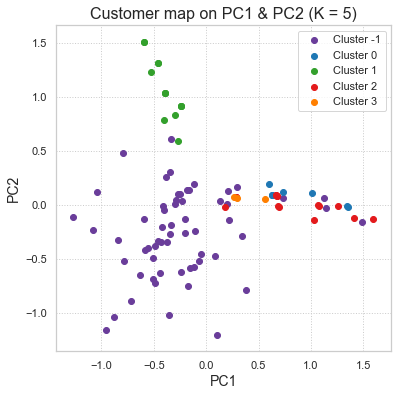

eps: 1.3


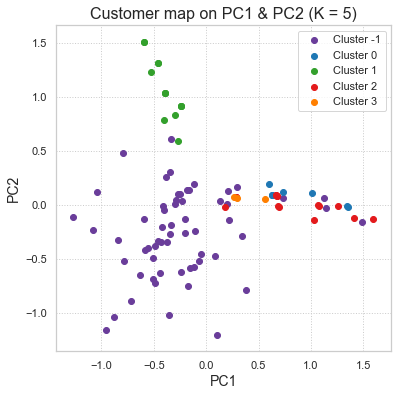

eps: 1.4


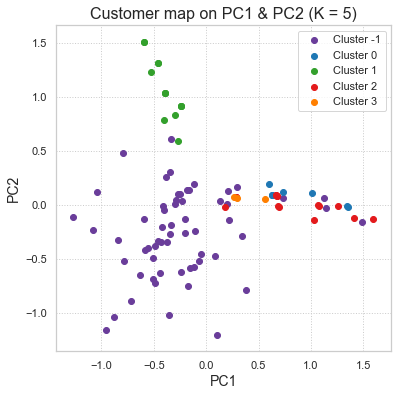

eps: 1.5


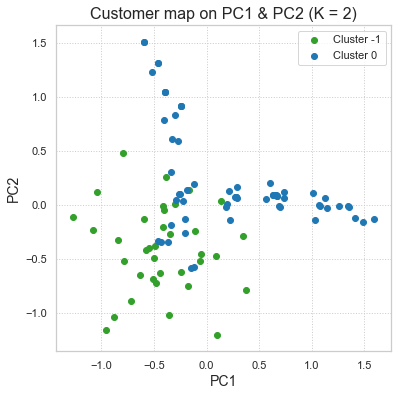

eps: 1.6


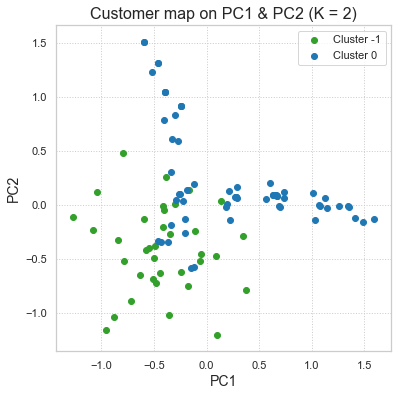

eps: 1.7


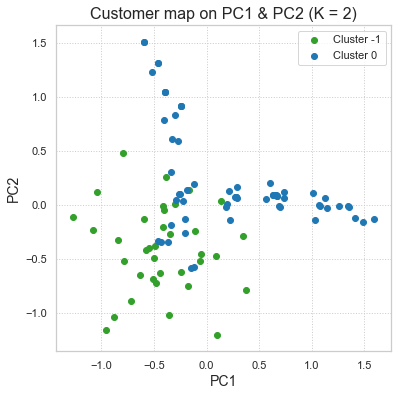

eps: 1.8


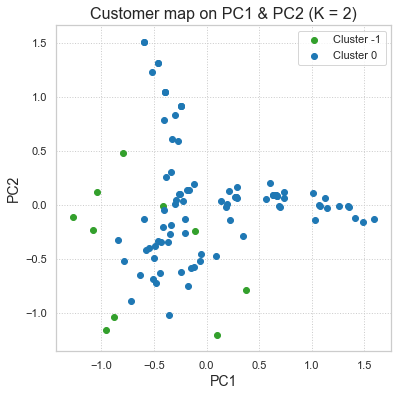

In [26]:
## DBSCAN
for eps in np.linspace(0.9, 1.8, 10):
    print("eps: {:.1f}".format(eps))
    _, _, _ = clustering_with_model(X, DBSCAN, reduction=False, annot=False, figsize=(6,6), eps=eps)


The DBSCAN model does not give a good result for our dataset regardless of eps (threshold distance) values. Given the result, we can assume that our dataset is not well seperable density-wise. 

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. Reference below picture and description from [wikipedia](https://en.wikipedia.org/wiki/DBSCAN).


<table><tr>
    <td>
        <figure>
        <img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" style="height:300px" align='right'>
            <figcaption> (From wikipedia) </figcaption>
        </figure>
    </td>
</tr></table>

>In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

### Q. How do their results compare? Which performs the best? Tell a story why you think it performs the best.

Spectral clustering, agglomerative clustering show almost identical results when cluster number K is 3. The reason these three models show very similar results is they all strive to reduce the sum of squared, or somehow employ variance-minimizing approach. Our dataset is similar to the third row dataset from [Figure 1](#figure1), and our results is just re-confirming the third row results.